# Содержание

<br>[Описание](#intro)
<br>
<br>[Загрузка и подготовка данных](#unit1)
<br>
<br>[Обучение и проверка модели](#unit2)
<br>
<br>[Подготовка к расчету прибыли](#unit3)
<br>
<br>[Расчет прибыли и рисков](#unit4)
<br>
<br>[Риски и прибыль для каждого региона](#unit5)

# Выбор локации для скважины <a id='intro'></a>

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных <a id='unit1'></a>

Импортируем все необходимые библиотеки. Откроем данные и посмотрим на них

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from scipy.stats import t
import matplotlib.pyplot as plt

In [41]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [42]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [43]:
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [44]:
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [45]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Вывод: пропусков в данных нет, с ними можно начинать работать

-----------------

Выделим целевой признак из данных по каждому месторождению. Для нас это будет - объем сырья = 'product'

In [48]:
features0 = df0.drop(['product', 'id'], axis=1)
target0 = df0['product']

In [49]:
features1 = df1.drop(['product', 'id'], axis=1)
target1 = df1['product']

In [50]:
features2 = df2.drop(['product', 'id'], axis=1)
target2 = df2['product']

## Обучение и проверка модели <a id='unit2'></a>

### Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

In [51]:
features0_train, features0_valid, target0_train, target0_valid = train_test_split(
    features0, target0, test_size=0.25, random_state=12345)
target0_valid = target0_valid.reset_index(drop=True)

In [52]:
features1_train, features1_valid, target1_train, target1_valid = train_test_split(
    features1, target1, test_size=0.25, random_state=12345)
target1_valid = target1_valid.reset_index(drop=True)

In [53]:
features2_train, features2_valid, target2_train, target2_valid = train_test_split(
    features2, target2, test_size=0.25, random_state=12345)
target2_valid = target2_valid.reset_index(drop=True)

### Обучим модель и сделаем предсказания на валидационной выборке.

In [54]:
model0 = LinearRegression()
model0.fit(features0_train, target0_train)
predictions0_valid = model0.predict(features0_valid)

In [55]:
model1 = LinearRegression()
model1.fit(features1_train, target1_train)
predictions1_valid = model1.predict(features1_valid)

In [56]:
model2 = LinearRegression()
model2.fit(features2_train, target2_train)
predictions2_valid = model2.predict(features2_valid)

### Сохраним предсказанные значения и правильные ответы валидационной выборки

In [57]:
predict0 = predictions0_valid
target0 = target0_valid

In [58]:
predict1 = predictions1_valid
target1 = target1_valid

In [59]:
predict2 = predictions2_valid
target2 = target2_valid

### Вычислим средний запас предсказанного сырья и RMSE модели для каждого месторождения

In [60]:
result0 = mean_squared_error(target0, predict0)**0.5
print ('RMSE_0:',result0)
print ('Средний запас предсказанного сырья 0 месторождения:', predict0.mean(), 'тыс.барр.')

RMSE_0: 37.5794217150813
Средний запас предсказанного сырья 0 месторождения: 92.59256778438035 тыс.барр.


In [61]:
result1 = mean_squared_error(target1, predict1)**0.5
print ('RMSE_1:',result1)
print ('Средний запас предсказанного сырья 1 месторождения:', predict1.mean(), 'тыс.барр.')

RMSE_1: 0.893099286775617
Средний запас предсказанного сырья 1 месторождения: 68.728546895446 тыс.барр.


In [62]:
result2 = mean_squared_error(target2, predict2)**0.5
print ('RMSE_2:',result2)
print ('Средний запас предсказанного сырья 2 месторождения:', predict2.mean(), 'тыс.барр.')

RMSE_2: 40.02970873393434
Средний запас предсказанного сырья 2 месторождения: 94.96504596800489 тыс.барр.


### Анализ результатов пункта

Наилучшее значение метрики RMSE - у модели, предсказывающей запасы 1 месторождения. В то же время у нее самое низкое значение среднего запаса сырья, что может объясняться тем, что модель предсказала более реальные значения. Две других модели предсказали значения с гораздо большим разбросом, отсюда и RMSE выше в десятки раз, и среднее значение запасов сырья соответственно выше.

## Подготовка к расчёту прибыли <a id='unit3'></a>

### Сохраним в отдельных переменных ключевые значения для расчётов

Прибыль от 1 единицы продукции (1 тыс.баррелей), руб.

In [63]:
REV_PER_PRODUCT = 450000

Бюджет на разработку всех скважин в регионе, руб.

In [64]:
RESEARCH_BUDGET = 10**10

### Вычислим достаточный объём сырья для безубыточной разработки новой скважины

In [65]:
volume_for_research = round(RESEARCH_BUDGET/REV_PER_PRODUCT, 2)
print("Объем сырья для безубыточной разработки =",
      round(volume_for_research/200, 2), "тыс.барр.")

Объем сырья для безубыточной разработки = 111.11 тыс.барр.


Месторождение №0

In [66]:
print('Среднее значение запасов сырья =', 
      round(target0.mean()), "тыс.барр.")

Среднее значение запасов сырья = 92 тыс.барр.


Месторождение №1

In [67]:
print('Среднее значение запасов сырья =', 
      round(target1.mean()), "тыс.барр.")

Среднее значение запасов сырья = 69 тыс.барр.


Месторождение №2

In [68]:
print('Среднее значение запасов сырья =', 
      round(target2.mean()), "тыс.барр.")

Среднее значение запасов сырья = 95 тыс.барр.


### Выводы раздела

Значения средних запасов сырья (по имеющимся данным) сильно ниже порога безубыточной разработки. Но не стоит забывать, что это значения сырья, полученного от одной скважины. В нашем же распоряжении будет их гораздо больше.

## Расчёт прибыли и рисков  <a id='unit4'></a>

### Создадим функцию "profit" для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [69]:
def profit(target, predictions, count):
    preds_sorted = pd.Series(predictions).sort_values(ascending=False)
    selected = target[preds_sorted.index][:count]
    return selected.sum()*REV_PER_PRODUCT - RESEARCH_BUDGET

### Рассчитаем прибыль от полученного с 200 лучших скважин объёма сырья.

In [70]:
print("Прибыль от 200 лучших скважин 0 месторождения:", 
      round(profit(target0, predict0, 200)/10**9, 2), "млрд.руб.")

#переводим в единицы измерения "млрд.руб". делением на 10**9

Прибыль от 200 лучших скважин 0 месторождения: 3.32 млрд.руб.


In [71]:
print("Прибыль от 200 лучших скважин 1 месторождения:", 
      round(profit(target1, predict1, 200)/10**9, 2), "млрд.руб.")

Прибыль от 200 лучших скважин 1 месторождения: 2.42 млрд.руб.


In [72]:
print("Прибыль от 200 лучших скважин 2 месторождения:", 
      round(profit(target2, predict2, 200)/10**9, 2), "млрд.руб.")

Прибыль от 200 лучших скважин 2 месторождения: 2.71 млрд.руб.


## Риски и прибыль для каждого региона  <a id='unit5'></a>

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Также вычислим среднюю прибыль, доверительный интервал и риск убытков.

Средняя прибыль от 200 лучших скважин случайного сэмпла: 0.43 млрд.руб.
95%-ый доверительный интервал: (0.4087322070686986, 0.4431448467524861)
2,5%-квантиль: -0.1 млрд.руб.
97,5%-квантиль: 0.95 млрд.руб.


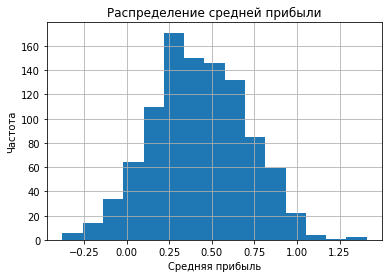

In [73]:
state = np.random.RandomState(12345) 

values0 = []
for i in range(1000):
    preds_subsample = pd.Series(predict0).sample(n=500, random_state=state, replace=True)
    target_subsample = target0[preds_subsample.index]
    values0.append(profit(target_subsample, preds_subsample, 200))

values0 = pd.Series(values0)/10**9  #переводим в единицы измерения "млрд.руб". делением на 10**9
lower0 = values0.quantile(0.025)
upper0 = values0.quantile(0.975)
confidence_interval = st.t.interval(0.95, len(values0)-1, loc=values0.mean(), scale=values0.sem()) 

print("Средняя прибыль от 200 лучших скважин случайного сэмпла:", round(values0.mean(), 2), "млрд.руб.")
print("95%-ый доверительный интервал:", confidence_interval)
print("2,5%-квантиль:", round(lower0, 2), "млрд.руб.")
print("97,5%-квантиль:", round(upper0, 2), "млрд.руб.")

values0.plot(kind='hist', grid=True, bins=15)
plt.title("Распределение средней прибыли")
plt.xlabel("Средняя прибыль")
plt.ylabel("Частота")
plt.show()

In [74]:
print('Вероятность убытков для полученных выборок 0 месторождения =', 
      len(values0.loc[values0 <0])/len(values0)*100, '%')

Вероятность убытков для полученных выборок 0 месторождения = 6.0 %


Средняя прибыль от 200 лучших скважин случайного сэмпла: 0.52 млрд.руб.
95%-ый доверительный интервал: (0.5016214761763217, 0.5288240707102579)
2,5%-квантиль: 0.07 млрд.руб.
97,5%-квантиль: 0.93 млрд.руб.


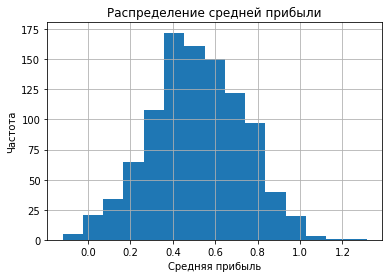

In [75]:
state = np.random.RandomState(12345) 

values1 = []
for i in range(1000):
    preds_subsample = pd.Series(predict1).sample(n=500, random_state=state, replace=True)
    target_subsample = target1[preds_subsample.index]
    values1.append(profit(target_subsample, preds_subsample, 200))

values1 = pd.Series(values1)/10**9  #переводим в единицы измерения "млрд.руб". делением на 10**9
lower1 = values1.quantile(0.025)
upper1 = values1.quantile(0.975)
confidence_interval = st.t.interval(0.95, len(values1)-1, loc=values1.mean(), scale=values1.sem()) 

print("Средняя прибыль от 200 лучших скважин случайного сэмпла:", round(values1.mean(), 2), "млрд.руб.")
print("95%-ый доверительный интервал:", confidence_interval)
print("2,5%-квантиль:", round(lower1, 2), "млрд.руб.")
print("97,5%-квантиль:", round(upper1, 2), "млрд.руб.")

values1.plot(kind='hist', grid=True, bins=15)
plt.title("Распределение средней прибыли")
plt.xlabel("Средняя прибыль")
plt.ylabel("Частота")
plt.show()

In [76]:
print('Вероятность убытков для полученных выборок 1 месторождения =', 
      len(values1.loc[values1 <0])/len(values1)*100, '%')

Вероятность убытков для полученных выборок 1 месторождения = 1.0 %


Средняя прибыль от 200 лучших скважин случайного сэмпла: 0.44 млрд.руб.
95%-ый доверительный интервал: (0.4174535520413578, 0.45256317352415343)
2,5%-квантиль: -0.13 млрд.руб.
97,5%-квантиль: 0.97 млрд.руб.


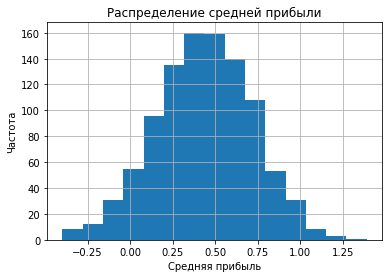

In [77]:
state = np.random.RandomState(12345) 

values2 = []
for i in range(1000):
    preds_subsample = pd.Series(predict2).sample(n=500, random_state=state, replace=True)
    target_subsample = target2[preds_subsample.index]
    values2.append(profit(target_subsample, preds_subsample, 200))

values2 = pd.Series(values2)/10**9  #переводим в единицы измерения "млрд.руб". делением на 10**9
lower2 = values2.quantile(0.025)
upper2 = values2.quantile(0.975)
confidence_interval = st.t.interval(0.95, len(values2)-1, loc=values2.mean(), scale=values2.sem()) 

print("Средняя прибыль от 200 лучших скважин случайного сэмпла:", round(values2.mean(), 2), "млрд.руб.")
print("95%-ый доверительный интервал:", confidence_interval)
print("2,5%-квантиль:", round(lower2, 2), "млрд.руб.")
print("97,5%-квантиль:", round(upper2, 2), "млрд.руб.")

values2.plot(kind='hist', grid=True, bins=15)
plt.title("Распределение средней прибыли")
plt.xlabel("Средняя прибыль")
plt.ylabel("Частота")
plt.show()

In [78]:
print('Вероятность убытков для полученных выборок 2 месторождения =', 
      len(values2.loc[values2 <0])/len(values2)*100, '%')

Вероятность убытков для полученных выборок 2 месторождения = 6.4 %


### Вывод

На основании полученных данных для разработки новых скважин наиболее подходит "Месторождение 1". Риск убытков при его разработке, согласно предсказаниям модели, составляет всего 1%. Для месторождений 0 и 2 значения риска - от 6%, что по условиям задачи является слишком высоким показателем. Кроме того, для месторождения 1 было получено самое высокое значение средней прибыли при вычислении техникой Бутстреп. 

<br>[Описание](#intro)
<br>[Загрузка и подготовка данных](#unit1)
<br>[Обучение и проверка модели](#unit2)
<br>[Подготовка к расчету прибыли](#unit3)
<br>[Расчет прибыли и рисков](#unit4)
<br>[Риски и прибыль для каждого региона](#unit5)